In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dataset = 'classa'

In [3]:
# Read our results

import json

def combine_dict(dict1, dict2):
    for key in dict2.keys():
        if key in dict1:
            dict1[key] = combine_dict(dict1[key], dict2[key])
        else:
            dict1[key] = dict2[key]
    return dict1

def combine_dicts(dicts):
    u = None
    for d in dicts:
        if u is None:
            u = d
        else:
            u = combine_dict(u, d)
    return u

In [4]:
import site

site.addsitedir("/home/xyhang/projects/VCIP2023-grand-challenge/")

from tools.bdrate import BD_RATE, BD_PSNR

In [5]:
from dataclasses import dataclass
from typing_extensions import TypeAlias, List, Dict
import numpy as np

@dataclass
class ResultUnit:
    r: float
    d: float
    t: float

ImageResults: TypeAlias = List[ResultUnit]

class DatasetResults:
    def __init__(self):
        self.img_results: Dict[str, ImageResults] = {}

    def update_image_result(self, img_name, r, d, t):
        self.img_results.setdefault(img_name, []).append(ResultUnit(r=r, d=d, t=t))

    def sort(self):
        for k in self.img_results.keys():
            self.img_results[k].sort(key=lambda x: x.r)

    @property
    def avg_r(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.r for x in rs]))
        return results

    @property
    def avg_d(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.d for x in rs]))
        return results

    @property
    def avg_t(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.t for x in rs]))
        return results

    def _bd_rate_imgwise(self, anchor, min_int=None, max_int=None):
        self.sort()
        anchor.sort()
        ans = {}
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            R1 = np.unique(R1)
            R2 = np.unique(R2)
            D1 = np.unique(D1)
            D2 = np.unique(D2)

            if min_int is not None and max_int is not None:
                bd_rate = BD_RATE(R1, D1, R2, D2, min_int=min_int[filename], max_int=max_int[filename])
            else:
                bd_rate = BD_RATE(R1, D1, R2, D2)

            ans[filename] = bd_rate
        return ans

    def bd_rate(self, anchor, min_int=None, max_int=None):
        ans = self._bd_rate_imgwise(anchor, min_int, max_int)
        return np.mean(list(ans.values()))

    def bd_psnr(self, anchor):
        self.sort()
        anchor.sort()
        ans = []
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            R1 = np.unique(R1)
            R2 = np.unique(R2)
            D1 = np.unique(D1)
            D2 = np.unique(D2)
            bd_rate = BD_PSNR(R1, D1, R2, D2)
            ans.append(bd_rate)
        return np.mean(ans)

    def time_saving(self, anchor):
        self.sort()
        anchor.sort()
        ans = []

In [6]:
def read_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [7]:
import glob

results = glob.glob(f"{dataset}/*.json")

data_ours = combine_dicts([read_json(r) for r in results])

In [8]:
# speedups = [0.01, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
speedups = [0.01,0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0]
qscales = [0.1, 0.3, 0.5, 0.7, 0.9]
# qscales = [0.3,0.4,0.5,0.6,0.7]

In [9]:
ours_results = {k: DatasetResults() for k in speedups}

for speedup in speedups:
    for qscale in qscales:
        glob_results = data_ours[f"qscale={qscale}"][f"speedup={speedup}"]
        for filename, result in glob_results.items():
            if filename[:3] != "avg":
                ours_results[speedup].update_image_result(
                    filename, result["bpp"], result["PSNR"], result["t_dec"]
                )

In [10]:
import pandas as pd

def read_xls(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

In [11]:
anchors = ['bpg', 'evc', 'jpeg', 'mlic', 'qarv', 'tcm', 'webp', 'vtm']

anchor_results: Dict[str, DatasetResults] = {k: DatasetResults() for k in anchors}

anchors_r = {}
anchors_d = {}
anchors_t = {}

for anchor in anchors:
    if anchor == 'vtm':
        xls_data: pd.DataFrame = read_xls(f"VTM.xls", dataset)
        filename = None
        for index, x in xls_data.iterrows():
            if isinstance(x.Filename, (str, int)) or (isinstance(x.Filename, float) and not np.isnan(x.Filename)):
                if isinstance(x.Filename, float):
                    filename = str(int(x.Filename))
                else:
                    filename = str(x.Filename)
            anchor_results[anchor].update_image_result(
                filename, x.bpp, x["RGB psnr"], x["Dec Time"] * 12.387
            )
    else:
        anchor_data = read_json(f"../../anchors/{dataset}/{anchor}/results.json")
        if anchor == 'bpg' and dataset == 'classa':
            for t1 in anchor_data.values():
                for t2 in t1.values():
                    for filename, result in t2.items():
                        if filename[:3] != "avg":
                            anchor_results[anchor].update_image_result(
                                filename, result["bpp"], result["PSNR"], result["t_dec"]
                            )
        else:
            for t2 in anchor_data.values():
                for filename, result in t2.items():
                    if filename[:3] != "avg":
                        anchor_results[anchor].update_image_result(
                            filename, result["bpp"], result["PSNR"], result["t_dec"]
                        )

In [12]:
import scipy


def interpolator(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    lin = np.linspace(min(x), max(x), num=100, retstep=True)
    samples = lin[0]
    v = scipy.interpolate.pchip_interpolate(
        np.sort(x), y[np.argsort(x)], samples
    )

    return samples, v

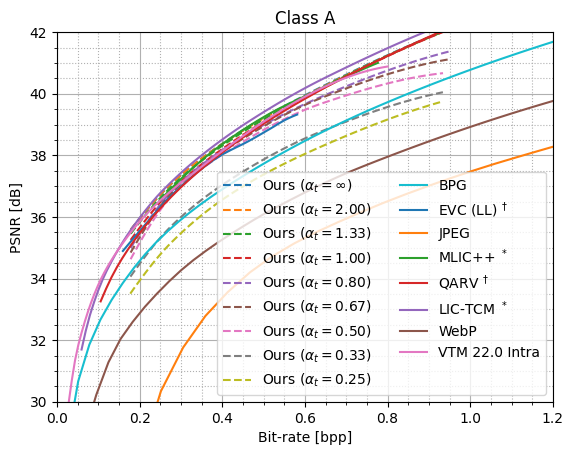

In [13]:
plt.figure(figsize=(6.4, 4.8))

name_mapping = {
    "evc": r"EVC (LL) $^\dag$",
    "mlic": "MLIC++ $^*$",
    "tcm": "LIC-TCM $^*$",
    "vtm": "VTM 22.0 Intra",
    "qarv": "QARV $^\dag$",
    "bpg": "BPG",
    "webp": "WebP",
    "jpeg": "JPEG",
}

for speedup in speedups:
    r = ours_results[speedup].avg_r
    d = ours_results[speedup].avg_d
    r, d = interpolator(r, d)

    dt = 1.0 / speedup
    label = (
        f"Ours ($\\alpha_t={dt:.2f}$)" if dt <= 10 else f"Ours ($\\alpha_t=\\infty$)"
    )

    plt.plot(
        r,
        d,
        linestyle="--",
        label=label,
    )

for k, v in anchor_results.items():
    r = v.avg_r
    d = v.avg_d
    r, d = interpolator(r, d)
    plt.plot(r, d, label=name_mapping[k])
plt.legend(ncol=2)
plt.xlim(0.0, 1.2)
plt.ylim(30, 42)

plt.xlabel("Bit-rate [bpp]")
plt.ylabel("PSNR [dB]")
plt.minorticks_on()
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle=":")
titles = {
    "classa": "Class A",
    "classb": "Class B",
    "classc": "Class C",
    "classd": "Kodak",
}
plt.title(titles[dataset])

plt.savefig(f"{dataset}_rd.pdf", bbox_inches="tight")
plt.savefig(f"{dataset}_rd.png", dpi=600, bbox_inches="tight")
plt.show()

{'DOG_4507': 37.03661849477224, 'DSC07099': 33.94674947240286, 'DSC07705': 33.8538592097991, 'DSC08582': 34.963611864828394, 'DSC08626': 40.77764978387289, 'DSC08672': 33.23684861638479, 'DSC08796': 32.067240977072046, 'DSC08892': 35.86183001973562, 'DSC08902': 37.7948992488616, 'DSC08928': 36.77709271886282, 'DSC08936': 38.79318883397512, 'DSC_3889': 36.6490035293334, 'IMG_1813': 33.69363357999258, 'IMG_3227': 38.99428656079702, 'IMG_3261': 39.53835179784231, 'IMG_3412': 36.435851359152124, 'IMG_3515': 35.93480637051992, 'IMG_3799': 37.71086027600698, 'IMG_4684': 36.76716377713613, 'IMG_4700': 33.973989987158106, 'IMG_6726': 36.75295164563589, 'IMG_7136': 35.540335678839014, 'IMG_8176': 37.064728045248316, 'IMG_8795': 41.95022990682058}
{'DOG_4507': 40.251286530279444, 'DSC07099': 36.802360319876, 'DSC07705': 37.395921253942774, 'DSC08582': 37.8781442878478, 'DSC08626': 42.30256547906332, 'DSC08672': 36.54805829503469, 'DSC08796': 34.83493974187307, 'DSC08892': 38.365077280782984, 'DS

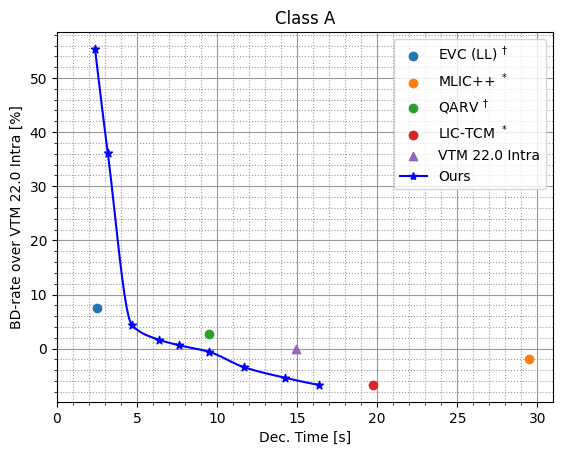

In [14]:
anchor = anchor_results['vtm']
min_int = {}
max_int = {}

for filename in anchor.img_results.keys():
    min_int[filename] = max(
        [
            min([x.d for x in data.img_results[filename]])
            for data in anchor_results.values()
        ]
        + [
            min([x.d for x in data.img_results[filename]])
            for data in ours_results.values()
        ]
    )
    max_int[filename] = min(
        [
            max([x.d for x in data.img_results[filename]])
            for data in anchor_results.values()
        ]
        + [
            max([x.d for x in data.img_results[filename]])
            for data in ours_results.values()
        ]
    )

print(min_int)
print(max_int)

ts = {}
bds = {}

for k, v in anchor_results.items():
    bd = v.bd_rate(anchor, min_int, max_int)
    t = np.mean(v.avg_t)
    ts[k] = t
    bds[k] = bd

for k, v in anchor_results.items():
    if k == 'evc':
        ts[k] = ts['qarv'] / 3.8
    if k not in ['jpeg', 'bpg', 'webp']:
        marker = '^' if k == 'vtm' else 'o'
        plt.scatter(ts[k], bds[k], label=name_mapping[k], zorder=10, marker=marker)
    print(k, ts[k], bds[k])

ours_bd = []
ours_t = []

for k, v in ours_results.items():
    bd = v.bd_rate(anchor, min_int, max_int)
    t = np.mean(v.avg_t)
    t = min(t, ts['qarv'] / k)
    if k == 0.01:
        bd = min(bd, bds['tcm'])
    # if bd < evc_bd or t < evc_t:
    ours_bd.append(bd)
    ours_t.append(t)
    print(k, t, bd)

t, bd = interpolator(ours_t, ours_bd)

plt.plot(t, bd, color='blue')
plt.scatter(ours_t, ours_bd, marker='*', color='blue', zorder=10)
plt.plot([-1], [0], marker="*", color="blue", label="Ours")
plt.xlabel("Dec. Time [s]")
plt.xlim(0, None)
plt.ylabel("BD-rate over VTM 22.0 Intra [%]")
plt.minorticks_on()
plt.grid(zorder=0, which='major', color='#999999', linestyle='-')
plt.grid(zorder=0, which='minor', color='#999999', linestyle=':')
titles = {
    "classa": "Class A",
    "classb": "Class B",
    "classc": "Class C",
    "classd": "Kodak",
}
plt.title(titles[dataset])
plt.legend()

plt.savefig(f"{dataset}_bd_c.pdf", bbox_inches='tight')
plt.savefig(f"{dataset}_bd_c.png", dpi=600, bbox_inches="tight")

In [15]:
if dataset == "classd":
    gao_t = np.array([0.2, 1.7, 3.1, 4.4, 7.3]) / 2.0
    gao_bd = [8.7, 6.0, 5.0, 4.0, 3.0]
    t, bd = interpolator(gao_t, gao_bd)
    plt.plot(t, bd, color="black")
    plt.scatter(gao_t, gao_bd, marker="<", color="black")
    plt.plot([-1], [0], color="black", marker="<", label="Gao et.al")

    t, bd = interpolator(ours_t, ours_bd)

    plt.plot(t, bd, color="blue")
    plt.scatter(ours_t, ours_bd, marker="*", color="blue", zorder=10)
    plt.plot([-1], [0], marker="*", color="blue", label="Ours")
    plt.xlabel("Dec. Time [s]")
    plt.xlim(0, None)
    plt.ylabel("BD-rate over VTM 22.0 Intra [%]")
    plt.minorticks_on()
    plt.grid(zorder=0, which="major", color="#999999", linestyle="-")
    plt.grid(zorder=0, which="minor", color="#999999", linestyle=":")
    titles = {
        "classa": "Class A",
        "classb": "Class B",
        "classc": "Class C",
        "classd": "Kodak",
    }
    plt.title(titles[dataset])
    plt.legend()

    plt.savefig(f"{dataset}_bd_gao.pdf", bbox_inches="tight")
    plt.savefig(f"{dataset}_bd_gao.png", dpi=600, bbox_inches="tight")

In [16]:
# Accelerate Effect

import scipy.interpolate


for method in ts.keys():
    t = ts[method]
    bd = bds[method]

    t_est = scipy.interpolate.pchip_interpolate(ours_bd, ours_t, bd)
    print(method, 100*(t_est-t)/t)

bpg -63.06503263812366
evc 73.85749916685835
jpeg -2768.1979831169224
mlic -63.986185865608974
qarv -42.048502862708276
tcm -17.25107384725474
webp -159.6464224718204
vtm -42.28351628923642


In [17]:
# Accelerate Effect

import scipy.interpolate

ours_t = np.asarray(ours_t)
ours_bd = np.asarray(ours_bd)

print(ours_t, ours_bd, flush=True)

for method in ts.keys():
    t = ts[method]
    bd = bds[method]
    if t > max(ours_t):
        bd_est = min(ours_bd)
    else:
        X = np.sort(ours_t)
        Y = ours_bd[np.argsort(ours_t)]
        bd_est = scipy.interpolate.pchip_interpolate(X, Y, t)
    print(method, bd_est - bd)

[16.35336508 14.22935894 11.67001507  9.5258653   7.62069224  6.35057687
  4.69026991  3.17528843  2.38146633] [-6.70305995 -5.37337594 -3.41408888 -0.61870607  0.63581355  1.66599165
  4.30870328 36.17705828 55.37343466]


bpg -41.80755114986534
evc 44.714936989141314
jpeg -147.94448301936694
mlic -4.719326907474196
qarv -3.2675661374182265
tcm 0.0
webp -35.57823362639053
vtm -5.859261729341792


In [18]:
import matplotlib as mpl

def plot_img_results(results: DatasetResults, anchor: DatasetResults, rng_anchor: DatasetResults = None):
    ans_results = results._bd_rate_imgwise(anchor, min_int, max_int)
    ans_results = [(k, v) for k, v in ans_results.items()]
    ans_results.sort(key=lambda x: x[1])
    print(ans_results)
    plt.figure(figsize=(10, 3))

    cm = mpl.colormaps['coolwarm']
    labels, values = zip(*ans_results)
    colors = np.asarray(values)
    colors = colors / (np.abs(colors).max())
    colors = colors / 2 + 0.5
    colors = [cm(k) for k in colors]
    plt.bar(labels, values, color=colors, zorder=10)
    plt.ylabel("BD-rate (%)")
    plt.grid(axis='y', zorder=0)
    plt.xticks(rotation=90)

In [19]:
import matplotlib as mpl


def plot_img_results_comparison(
    results1: DatasetResults, results2, anchor: DatasetResults
):
    ans_results1 = results1._bd_rate_imgwise(anchor)
    ans_results2 = results2._bd_rate_imgwise(anchor)
    ans_results2 = [(k, ans_results1[k] - v) for k, v in ans_results2.items()]
    ans_results2.sort(key=lambda x: x[1])
    print(ans_results2)
    plt.figure(figsize=(10, 3))

    cm = mpl.colormaps["coolwarm"]
    labels, values = zip(*ans_results2)
    colors = np.asarray(values)
    colors = colors / (np.abs(colors).max())
    colors = colors / 2 + 0.5
    colors = [cm(k) for k in colors]
    plt.bar(labels, values, color=colors, zorder=10)
    plt.ylabel("BD-rate (%)")
    plt.grid(axis="y", zorder=0)
    plt.xticks(rotation=90)

[('DSC_3889', -0.218022080758562), ('DOG_4507', -0.15301728996084396), ('DSC08626', 0.042044214584779915), ('DSC08892', 0.14557481984707188), ('DSC07099', 0.19826490120242735), ('DSC08902', 0.20429262277885663), ('DSC07705', 0.2800240977449908), ('DSC08928', 0.5178140197790393), ('DSC08796', 0.5742002061405183), ('DSC08936', 0.9050209037452683), ('IMG_3261', 0.9363787660113365), ('IMG_3515', 0.9783931552703296), ('DSC08582', 1.1192884560645044), ('IMG_3412', 1.3034339430324504), ('IMG_1813', 1.5379499851131184), ('IMG_3799', 1.6733635136312985), ('IMG_7136', 1.698965439774991), ('DSC08672', 1.7574814248872306), ('IMG_8176', 1.9450772863319754), ('IMG_3227', 2.9496767679886515), ('IMG_6726', 3.09378024415341), ('IMG_4700', 3.2607181219536985), ('IMG_4684', 3.641352421623867), ('IMG_8795', 4.451268866983393)]


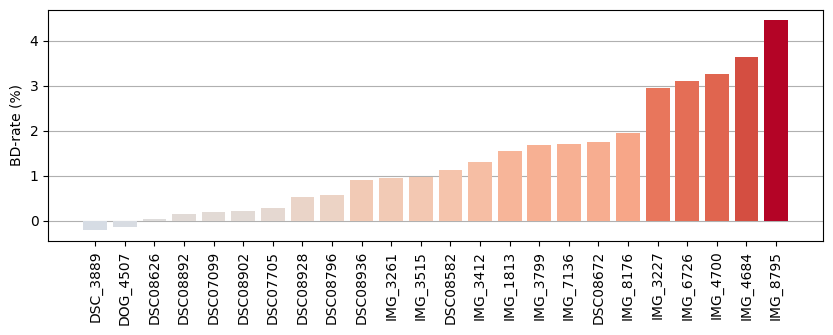

In [20]:
plot_img_results(ours_results[0.01], anchor_results["tcm"])

[('IMG_8795', -35.185079115939686), ('IMG_3227', -22.219742957673915), ('DSC08936', -12.823625984176058), ('DSC08902', -10.683032540087488), ('IMG_3261', -9.686159646050108), ('DSC08626', -9.184033323435504), ('IMG_3799', -9.086851104374782), ('IMG_8176', -8.406311296465717), ('DSC_3889', -5.608653810687292), ('IMG_7136', -5.181438912374125), ('DSC07099', -4.727189433799161), ('DSC08928', -4.4952812673053835), ('DSC08892', -4.439717045638825), ('DOG_4507', -3.6577753343325803), ('IMG_4684', -3.548752988644055), ('IMG_3515', -3.0854179852677905), ('IMG_1813', -3.059588608808983), ('DSC07705', -2.962138008967319), ('IMG_3412', -2.9368299095425154), ('IMG_6726', -2.2425531790298816), ('DSC08582', -1.5108901466423186), ('IMG_4700', -1.51052719732132), ('DSC08796', -1.4777696221328407), ('DSC08672', 0.18222219231267545)]


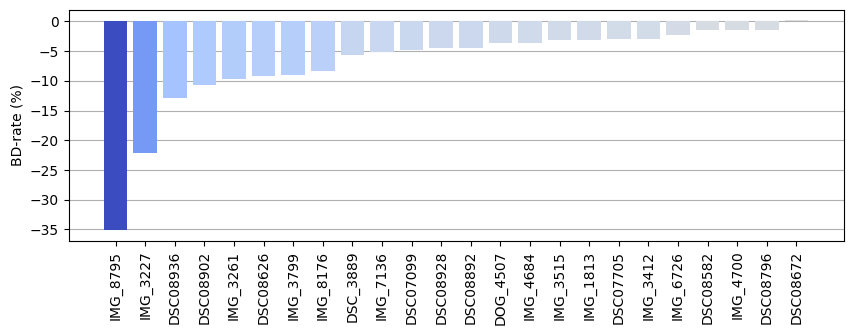

In [21]:
plot_img_results_comparison(ours_results[0.01], anchor_results["tcm"], anchor_results["vtm"])
plt.savefig("ours_tcm_imgwise.pdf", bbox_inches="tight")
plt.savefig("ours_tcm_imgwise.png", dpi=600, bbox_inches="tight")

[('IMG_8795', -27.785872020471245), ('IMG_3227', -17.263746265501442), ('DSC08902', -16.73690825779164), ('IMG_3261', -16.34941107855663), ('DSC08936', -15.362169812035953), ('DSC08626', -9.787019564030876), ('IMG_3799', -9.679913151213315), ('DSC08928', -9.299745652312897), ('IMG_3412', -9.046396663873423), ('DOG_4507', -7.06815218710275), ('IMG_6726', -6.943766501485838), ('IMG_8176', -6.8161404697894), ('IMG_3515', -6.519305712688128), ('IMG_4684', -6.352772249436112), ('DSC08892', -6.125932736491091), ('DSC07099', -5.46421919109923), ('IMG_7136', -5.392417260284677), ('DSC_3889', -5.305747043902242), ('DSC08582', -4.553079863358534), ('IMG_4700', -4.385138296704216), ('IMG_1813', -3.9170063479675665), ('DSC08796', -2.7486414110947877), ('DSC07705', -2.2889516998405917), ('DSC08672', -1.5269950700514512)]


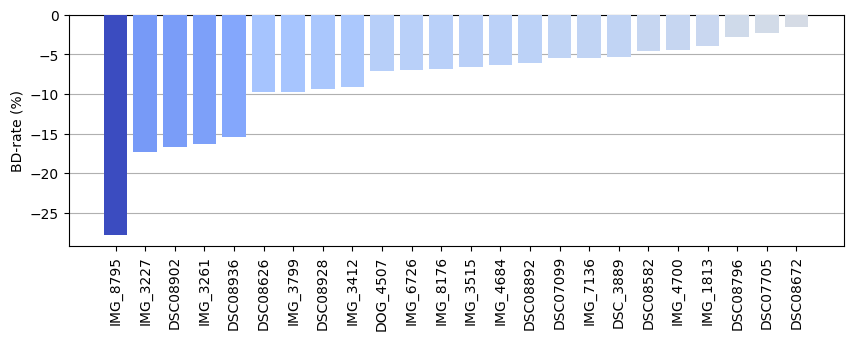

In [22]:
plot_img_results_comparison(
    ours_results[1.0], anchor_results["qarv"], anchor_results["vtm"]
)
plt.savefig("ours_qarv_imgwise.pdf", bbox_inches='tight')
plt.savefig("ours_qarv_imgwise.png", dpi=600, bbox_inches="tight")

[('DSC08892', -9.861583131897177), ('DSC08928', -7.647345490309021), ('DOG_4507', -7.207526090953198), ('DSC08796', -5.81988297799223), ('IMG_6726', -5.432060558883133), ('DSC07099', -5.363544266117137), ('DSC_3889', -4.087415968672126), ('IMG_4700', -3.496694627204655), ('IMG_3412', -2.9775045933545963), ('IMG_8176', -2.816356985081292), ('IMG_1813', -2.681546566125992), ('DSC08902', -2.3659019612707666), ('DSC08672', -2.225507152999706), ('DSC08936', -2.111940921271971), ('IMG_8795', -1.8534162772471219), ('IMG_4684', -1.5097160408793608), ('IMG_3799', -1.444165361848937), ('IMG_3515', -1.3489736897428384), ('DSC08582', -1.3221544845924527), ('DSC07705', -1.3124611405069708), ('IMG_3261', -0.07080991141049653), ('IMG_3227', 0.5787001574711015), ('IMG_7136', 0.6026771120228425), ('DSC08626', 0.9011786291550861)]


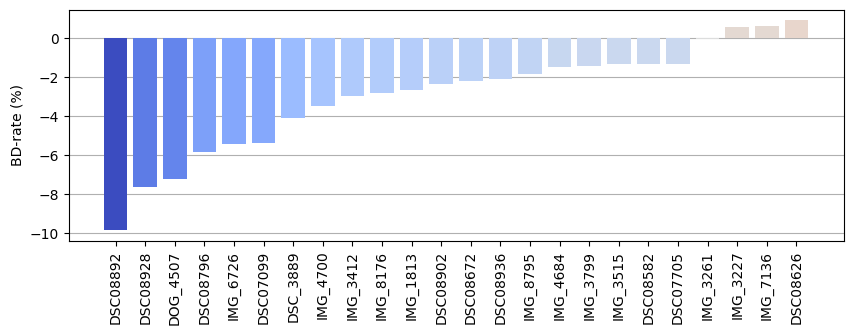

In [23]:
plot_img_results(
    ours_results[2.0], anchor_results["evc"]
)

In [24]:
def f(imgresult, label):
    plt.plot([x.r for x in imgresult], [x.d for x in imgresult], label=label, marker='o')

f(anchor_results["vtm"].img_results["pexels-photo-1537168_1"], "vtm")
f(anchor_results["tcm"].img_results["pexels-photo-1537168_1"], "tcm")
# f(anchor_results["mlic"].img_results["DSC05885"], "mlic")
f(ours_results[0.01].img_results["pexels-photo-1537168_1"], "ours")
plt.legend()

KeyError: 'pexels-photo-1537168_1'

In [ ]:
from src.fileio import FileIO

glb3 = glob.glob("classc/PSNR/speedup-2.0/*/DSC08927.bin")

for filename in glb3:
    fileio = FileIO.load(filename, False, 512)
    print(filename, fileio.method_id)

classc/PSNR/speedup-2.0/qscale-0.1/DSC08927.bin [1 4 0 4 4 1 0 1 4 0 0 1]
classc/PSNR/speedup-2.0/qscale-0.7/DSC08927.bin [1 1 0 1 1 1 1 1 1 1 1 1]
classc/PSNR/speedup-2.0/qscale-0.5/DSC08927.bin [1 1 0 1 1 1 0 1 1 1 1 4]
classc/PSNR/speedup-2.0/qscale-0.3/DSC08927.bin [1 1 0 4 4 1 0 1 4 0 0 4]
classc/PSNR/speedup-2.0/qscale-0.9/DSC08927.bin [1 1 0 1 1 1 1 1 1 0 1 1]


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 6.000e+00, 1.100e+01, 4.000e+00, 4.000e+00, 5.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 7.000e+00, 4.000e+00,
        8.000e+00, 9.000e+00, 2.200e+01, 1.800e+01, 3.000e+01, 3.400e+01,
        5.100e+01, 9.100e+01, 1.470e+02, 4.870e+02, 2.308e+03, 3.090e+02,
        1.270e+02, 6.100e+01, 4.600e+01, 3.700e+01, 2.800e+01, 2.000e+01,
        1.600e+01, 6.000e+00, 1.400e+01, 9.000e+00, 3.000e+00, 6.000e+00,
        1.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 6.000e+00,
        2.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+0

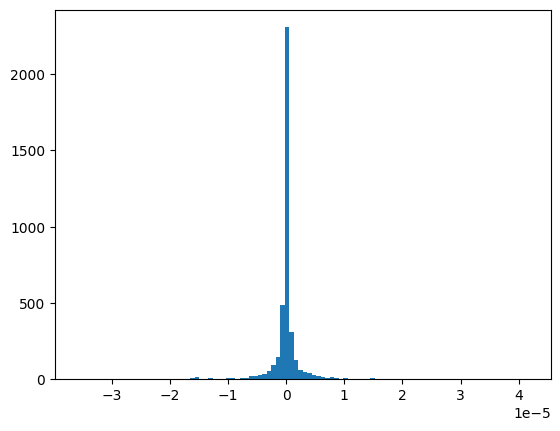

In [ ]:
glb_cache = glob.glob("/home/xyhang/projects/VCIP2023-grand-challenge/cache/PSNR/EVC_LL/*/*/b_t.npy")
xs = []

for filename in glb_cache:
    x = np.load(filename)
    xs.append(x)

plt.hist(np.asarray(xs)[:, 0], 100)

[('pexels-photo-984888_1', -21.579941365174747), ('pexels-photo-2189665_1', -17.531154055076538), ('pexels-photo-70441_1', -15.65915421070142), ('pexels-photo-816233_1', -14.631447111874007), ('pexels-photo-1537168_1', -14.545567447995811), ('pexels-photo-564065_1', -13.810793510100904), ('pexels-photo-2189712_1', -12.811794825970512), ('pexels-photo-1135448_1', -8.783346594766128), ('pexels-photo-212185_1', -8.522805908382235), ('pexels-photo-1559818_1', -8.477396499086431), ('pexels-photo-449011_1', -7.047784937464774), ('pexels-photo-1111766_1', -6.622012293919877), ('pexels-photo-326916_1', -6.0633481744235995), ('pexels-photo-1769361_1', -3.7444080243128286), ('pexels-photo-1750378_1', -2.8070393502928837), ('pexels-photo-548084_1', -2.653892262573021), ('pexels-photo-735986_1', -0.3619494326840389), ('pexels-photo-381541_1', 3.0776076646196193), ('pexels-photo-1987174_1', 3.758625218374201), ('pexels-photo-1004517_1', 4.555025025944648), ('pexels-photo-1604141_1', 4.7643265130004

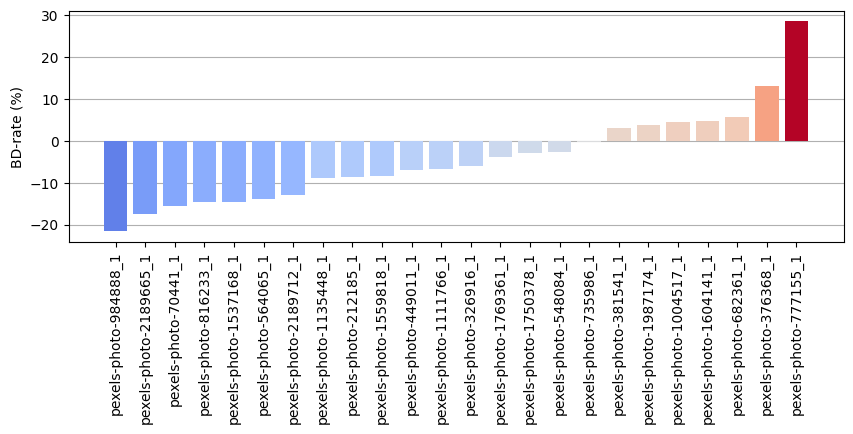

In [ ]:
plot_img_results(anchor_results['tcm'], anchor_results['vtm'], ours_results[0.5])

[('pexels-photo-984888_1', -20.989515051802464), ('pexels-photo-2189665_1', -16.855679212411523), ('pexels-photo-70441_1', -15.845851081194395), ('pexels-photo-816233_1', -13.15472787069767), ('pexels-photo-564065_1', -12.136957697137507), ('pexels-photo-2189712_1', -11.433970003163607), ('pexels-photo-1559818_1', -8.458060808040479), ('pexels-photo-1135448_1', -8.412065794585754), ('pexels-photo-212185_1', -7.875807152814518), ('pexels-photo-449011_1', -6.953595484350139), ('pexels-photo-1537168_1', -6.155018346199115), ('pexels-photo-326916_1', -5.3900811721432795), ('pexels-photo-1111766_1', -5.230654647467747), ('pexels-photo-1769361_1', -3.066939663643131), ('pexels-photo-548084_1', -1.4848756173422517), ('pexels-photo-1750378_1', -1.2741766710817948), ('pexels-photo-735986_1', 0.36390402733630367), ('pexels-photo-381541_1', 1.9466782040267416), ('pexels-photo-1987174_1', 4.751571507164787), ('pexels-photo-1604141_1', 5.786087607379287), ('pexels-photo-682361_1', 6.910631085718277

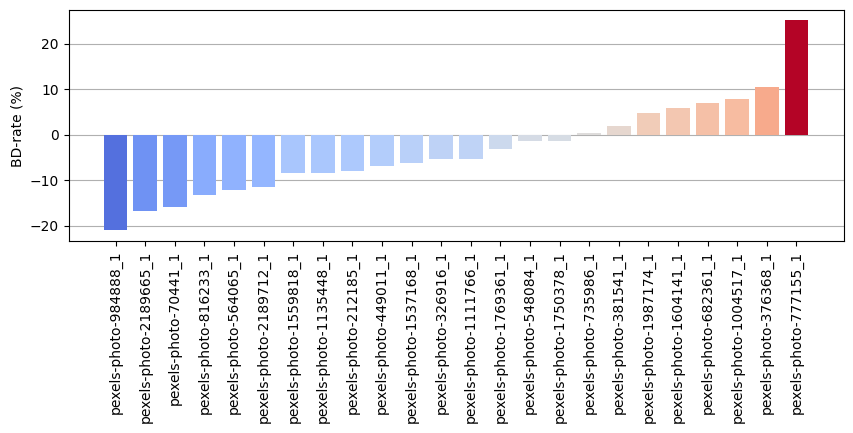

In [ ]:
plot_img_results(ours_results[0.5], anchor_results["vtm"])